In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import shap

## Load Data, Visualize Correlation

In [3]:
# Loading the dataset
data = pd.read_csv("data\concatenated_data_v3.csv") ##TODO
data.head()

,State,County,Operational,Shutdown,Potential,Any Landfill,ACSTOTPOP,ACSTOTHH,MINORPOP,LOWINCOME,...,PTRAF,PNPL,PRMP,PTSDF,UST,PWDIS,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT
0,AK,Aleutians West,0.0,0.0,1.0,1.0,5708,1306,4385,1109,...,0.000000,0.040295,1.940781,0.008495,0.003795,0.0,3.792628e+09,8.394545e+09,0.333333,0.333333
1,AK,Anchorage,1.0,0.0,1.0,1.0,292090,106970,126363,62252,...,633.067023,0.131820,0.869782,0.354112,5.700917,0.0,2.210296e+07,3.106511e+06,0.010000,0.015000
2,AK,Fairbanks North Star,0.0,0.0,1.0,1.0,98455,36199,30764,20062,...,185.155452,0.132946,0.222283,0.495616,3.572936,0.0,3.015408e+08,4.116561e+06,0.031746,0.079365
3,AK,Juneau,0.0,0.0,1.0,1.0,32099,12878,11733,5053,...,238.886591,0.003056,0.018862,0.015408,2.038204,0.0,3.334956e+08,6.791575e+07,0.000000,0.047619
4,AK,Kenai Peninsula,0.0,0.0,1.0,1.0,58809,21781,12245,15947,...,46.424096,0.008310,0.084909,0.055588,0.239602,0.0,1.185284e+09,6.440338e+08,0.000000,0.085714


<Axes: >

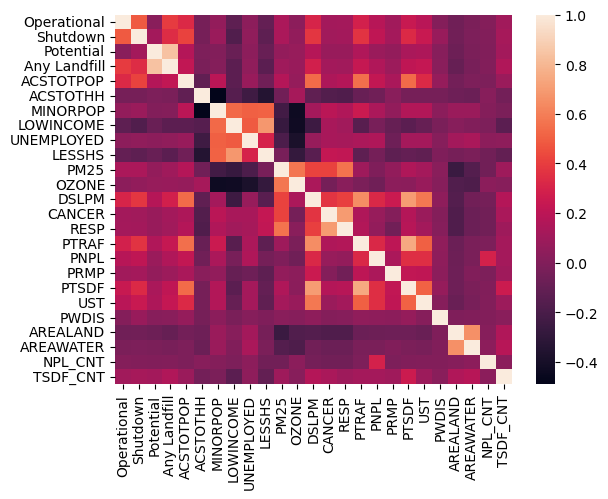

In [3]:
df = data.loc[:,'ACSTOTPOP':]

# change population dependence to percents
df.loc[:,"ACSTOTHH":"LESSHS"] = df.loc[:,"ACSTOTHH":"LESSHS"].div(df.loc[:,"ACSTOTPOP"], axis=0)

# change labels to be more relatable
# features = [
#        'TOTALPOP',
#        'HH_ENGLISH',
#        'MINORITY',
#        'LOWINCOME',
#        'UNEMPLOYED',
#        'LESSHS',
#        'PM25',
#        'OZONE',
#        'DSLPM',
#        'CANCER',
#        'RESP',
#        'P_TRAFFIC',
#        'P_SUPERFUND',
#        'P_RMP',
#        'P_HAZWASTE',
#        'UNDERGROUND_ST',
#        'WW_DISCHARGE',
#        'AREALAND',
#        'AREAWATER',
#        'BLOCK_SUPERFUND',
#        'BLOCK_HAZWASTE'   
# ]
# df.columns = features

# sns.heatmap(df.loc[:,"HH_ENGLISH":].corr())
sns.heatmap(pd.concat([data.loc[:,:"Any Landfill"], df], axis=1).corr())

## Add Region

In [4]:
region_dict = {
    'AL': 'South',
    'AK': 'West',
    'AZ': 'West',
    'AR': 'South',
    'CA': 'West',
    'CO': 'West',
    'CT': 'Northeast',
    'DE': 'South',
    'FL': 'South',
    'GA': 'South',
    'HI': 'West',
    'ID': 'West',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'IA': 'Midwest',
    'KS': 'Midwest',
    'KY': 'South',
    'LA': 'South',
    'ME': 'Northeast',
    'MD': 'South',
    'MA': 'Northeast',
    'MI': 'Midwest',
    'MN': 'Midwest',
    'MS': 'South',
    'MO': 'Midwest',
    'MT': 'West',
    'NE': 'Midwest',
    'NV': 'West',
    'NH': 'Northeast',
    'NJ': 'Northeast',
    'NM': 'West',
    'NY': 'Northeast',
    'NC': 'South',
    'ND': 'Midwest',
    'OH': 'Midwest',
    'OK': 'South',
    'OR': 'West',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'SC': 'South',
    'SD': 'Midwest',
    'TN': 'South',
    'TX': 'South',
    'UT': 'West',
    'VT': 'Northeast',
    'VA': 'South',
    'WA': 'West',
    'WV': 'South',
    'WI': 'Midwest',
    'WY': 'West',
    'AS': 'West', # American Samoa
    'DC': 'South', # District of Columbia
    'FM': 'West', # Federated States of Micronesia
    'GU': 'West', # Guam
    'MH': 'West', # Marshall Islands
    'MP': 'West', # Northern Mariana Islands
    'PW': 'West', # Palau
    'PR': 'South', # Puerto Rico
    'VI': 'South' # Virgin Islands
}

df = pd.concat([data.iloc[:,:2], pd.Series(data['State'].map(region_dict), name='Region'), data.iloc[:,2:]], axis=1)
# data['Region'] = data['State'].map(region_dict)
region_dummies = pd.get_dummies(df['Region'], prefix='Region')
df = pd.concat([data, region_dummies], axis=1)

df.head()

,State,County,Operational,Shutdown,Potential,Any Landfill,ACSTOTPOP,ACSTOTHH,MINORPOP,LOWINCOME,...,UST,PWDIS,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Region_Midwest,Region_Northeast,Region_South,Region_West
0,AK,Aleutians West,0.0,0.0,1.0,1.0,5708,1306,4385,1109,...,0.003795,0.0,3.792628e+09,8.394545e+09,0.333333,0.333333,0,0,0,1
1,AK,Anchorage,1.0,0.0,1.0,1.0,292090,106970,126363,62252,...,5.700917,0.0,2.210296e+07,3.106511e+06,0.010000,0.015000,0,0,0,1
2,AK,Fairbanks North Star,0.0,0.0,1.0,1.0,98455,36199,30764,20062,...,3.572936,0.0,3.015408e+08,4.116561e+06,0.031746,0.079365,0,0,0,1
3,AK,Juneau,0.0,0.0,1.0,1.0,32099,12878,11733,5053,...,2.038204,0.0,3.334956e+08,6.791575e+07,0.000000,0.047619,0,0,0,1
4,AK,Kenai Peninsula,0.0,0.0,1.0,1.0,58809,21781,12245,15947,...,0.239602,0.0,1.185284e+09,6.440338e+08,0.000000,0.085714,0,0,0,1


<Axes: >

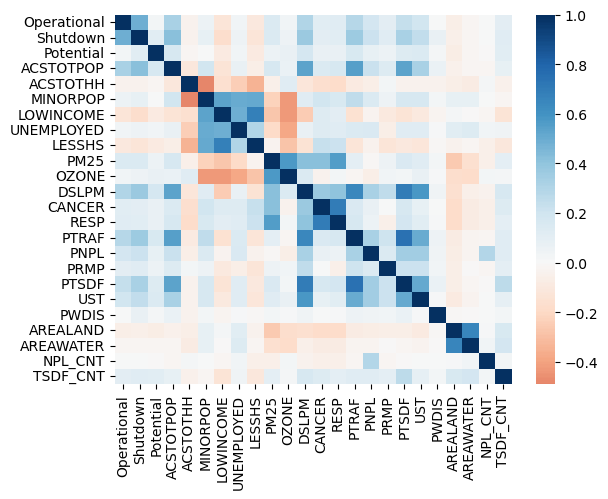

In [5]:
# more correlation
df = data.loc[:,'ACSTOTPOP':]

# change population dependence to percents
df.loc[:,"ACSTOTHH":"LESSHS"] = df.loc[:,"ACSTOTHH":"LESSHS"].div(df.loc[:,"ACSTOTPOP"], axis=0)
sns.heatmap(pd.concat([data.loc[:,"Operational":"Potential"], df], axis=1).corr(), yticklabels=1, xticklabels=1, center=0, cmap='RdBu')

## Random Forest Model

In [6]:
# Loading the dataset
data = pd.read_csv("data/concatenated_data_v3.csv") ##TODO
norm_cols = ['ACSTOTHH', 'MINORPOP', 'LOWINCOME', 'UNEMPLOYED', 'LESSHS']
data.loc[:,norm_cols] = data.loc[:,norm_cols].div(data.loc[:,'ACSTOTPOP'],axis=0)
data = data.dropna()
columns_to_drop = ['PM25', 'OZONE', 'DSLPM', 'CANCER', 'RESP', 'PNPL', 'NPL_CNT', 'TSDF_CNT',]
data.drop(columns_to_drop,axis=1, inplace=True)
feature_rename_dict = {
    "ACSTOTPOP": 'total population',
    "ACSTOTHH": 'households (limited English speaking)',
    "MINORPOP": 'num. people of color',
    "LOWINCOME": 'num. low income',
    "UNEMPLOYED": 'num. unemployed',
    "LESSHS": 'num. less than high school education',
    "PM25": 'particulate matter 2.5',
    "OZONE": 'ozone',
    "DSLPM": 'diesel particulate matter',
    "CANCER": 'air toxics cancer risk',
    "RESP": 'air toxics respiratory HI',
    "PTRAF": 'traffic proximity',
    "PNPL": 'superfund proximity',
    "PRMP": 'RMP facility proximity',
    "PTSDF": 'hazardous waste proximity',
    "UST": 'underground storage tanks',
    "PWDIS": 'wastewater discharge',
    "AREALAND": 'land area in square meters',
    "AREAWATER": 'water area in square meters',
    "NPL_CNT": 'num. superfund facilities in block group',
    "TSDF_CNT": 'num. hazardous waste facilities in block group',
}
data = data.rename(columns = feature_rename_dict)

# Prepare the data for training
features = data.loc[:, 'total population':].columns
X = data.loc[:, features].to_numpy() # Features
y = data.loc[:, 'Any Landfill'].to_numpy() # Target variable (0 or 1)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(
    X, y, data.index, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Getting the features to include
acc_big = pd.DataFrame()

base_features = []
base_features_n = []
for k in range(X_train.shape[1]):
    acc = pd.DataFrame()
    for i,n in zip(range(X_train.shape[1]),features):
        if n not in base_features:
            rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
            X_train_sub = X_train[:,base_features_n+[i]]
            rf_clf.fit(X_train_sub, y_train)
            # Make predictions on the test set
            y_pred = rf_clf.predict(X_test[:,base_features_n+[i]])
            # Evaluate the accuracy of the model
            test_accuracy = accuracy_score(y_test, y_pred)
            train_accuracy = accuracy_score(y_train, rf_clf.predict(X_train_sub))
            acc.loc[n,'Test accuracy'] = test_accuracy
            acc.loc[n,'Train accuracy'] = train_accuracy
    best_str = acc['Test accuracy'].idxmax()
    if best_str not in base_features:
        base_features += [best_str]
        base_features_n += [list(features).index(best_str)]
        acc_big.loc[k, 'Test accuracy'] = acc['Test accuracy'].max()
        acc_big.loc[k, 'Train accuracy'] = acc['Train accuracy'].max()

In [9]:
# set classifier with optimum features
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
features_to_use = base_features[:acc_big['Test accuracy'].idxmax()+1]
features_to_use_n = [list(features).index(i) for i in features_to_use]
X_train_sub = X_train[:,features_to_use_n]
rf_clf.fit(X_train_sub, y_train)
# Make predictions on the test set
y_pred = rf_clf.predict(X_test[:,features_to_use_n])
# Evaluate the accuracy of the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, rf_clf.predict(X_train_sub))
print('Train accuracy:',train_accuracy)
print('Test accuracy:',test_accuracy)

Train accuracy: 1.0
Test accuracy: 0.7311271975180972


## XGBoost

In [10]:
xgb_clf = xgb.XGBClassifier(n_estimators=5)
xgb_clf.fit(X=X_train[:,features_to_use_n], y=y_train)
y_pred = xgb_clf.predict(X_test[:,features_to_use_n])

train_accuracy = accuracy_score(y_train, xgb_clf(X_train[:,features_to_use_n]))
test_accuracy = accuracy_score(y_test, y_pred)
print('Train accuracy:',train_accuracy)
print('Test accuracy:',test_accuracy)

TypeError: 'XGBClassifier' object is not callable

## Clustering

In [46]:
totalpop = X_train[:,features_to_use_n[0]]
mean = totalpop.mean()
std = totalpop.std()

# categorize data by z-scores
thresholds = [mean - 3*std, mean - 2*std, mean - std, mean + std, mean + 2*std, mean + 3*std]
categories = ['<< 3 std', '<< 2 std', '<< 1 std', '>> 1 std', '>> 2 std', '>> 3 std']
categories = ['<< 3 std', '<< 2 std', '<< 1 std', '>> 1 std', '>> 2 std', '>> 3 std']

vals = lambda x: categories[np.digitize(x, thresholds)]

In [67]:
numBins = (totalpop.max() - totalpop.min() / 0.2*std)
numBins

31.452181238512946

In [68]:
sns.histplot(x=X[:,features_to_use_n[0]], stat='percent', binwidth=numBins) # arbitrarily set bins at 5% of std
plt.xlabel("total population")
# plt.xlim[0,0.3*1e7]

[0.33896259 0.24991549 0.14889036 0.10960633 0.07061003 0.04756331
 0.03445188]


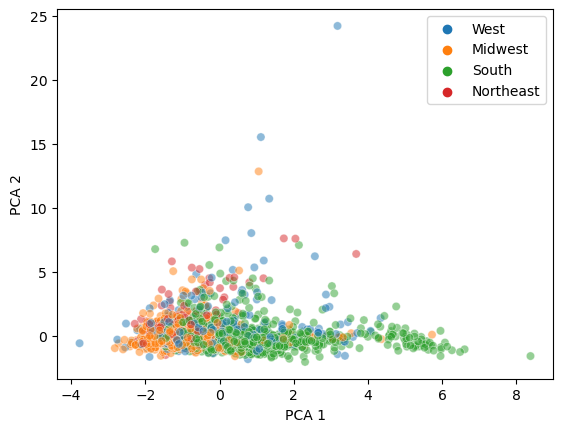

In [11]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_train[:,features_to_use_n])
print(pca.explained_variance_ratio_)

# # define the colors for each region using a dictionary
# region_colors = {
#     'Northeast': 'blue',
#     'South': 'red',
#     'Midwest': 'green',
#     'West': 'purple',
# }
# # create a list of colors for each data point based on its region
# region_labels = data['State'].map(region_dict)[ind_train].values
# point_colors = [region_colors[region] for region in region_labels]

# plt.scatter(X_pca[:,0], X_pca[:,1], c=point_colors, alpha=0.3)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], alpha=0.5,
                hue=data['State'].map(region_dict)[ind_train].values)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

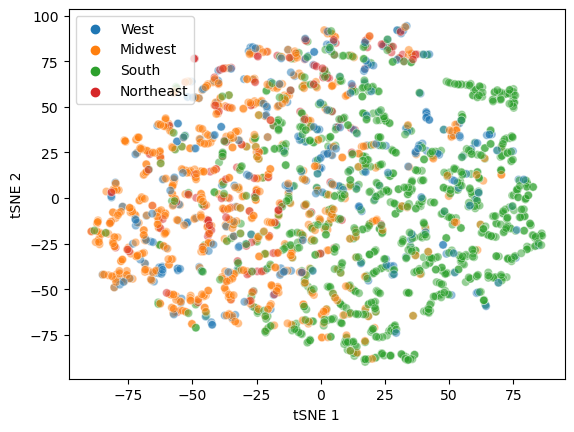

In [12]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(X_train[:,features_to_use_n])

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], alpha=0.5,
                hue=data['State'].map(region_dict)[ind_train].values)
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")

plt.show()

## Interpretability

array([[0.49, 0.51],
       [0.68, 0.32],
       [0.77, 0.23],
       ...,
       [0.59, 0.41],
       [0.63, 0.37],
       [0.74, 0.26]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


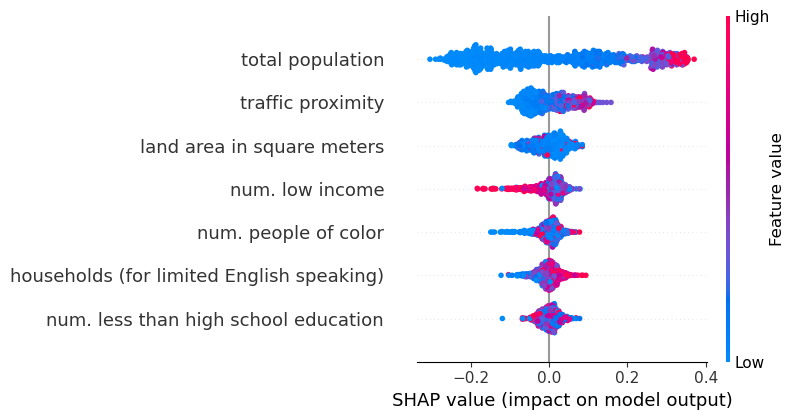

In [89]:
X_t = X_test[:,features_to_use_n]
# Explaining the predictions using SHAP values
explainer = shap.TreeExplainer(rf_clf)
# explainer = shap.explainers.Tree(rf_clf)
shap_values = np.array(explainer.shap_values(X_t))

# sum up SHAP values per class for all features and add to base values
# https://stackoverflow.com/questions/65549588/shap-treeexplainer-for-randomforest-multiclass-what-is-shap-valuesi
shap_values_ = shap_values.transpose((1,0,2))
np.allclose(
    rf_clf.predict_proba(X_t),
    shap_values_.sum(2) + explainer.expected_value
)

# Visualizing the summary plot of the SHAP values
shap.summary_plot(shap_values[1], X_t, feature_names=features_to_use) # model output = TRUE (shap_values[0] should be FALSE)
# shap.plots.beeswarm(shap_values)
# shap.summary_plot(shap_values[0], feature_names=features_to_use)
# shap.summary_plot(shap_values[1], feature_names=features_to_use)

In [106]:
# clustering
clustering = shap.utils.hclust(X_t, y_test)
shap.plots.bar(shap_values[1], clustering=clustering)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [100]:
# need initjs() b/c requires Javascript
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [49]:
# shap.summary_plot(shap_interaction_values, X_t)

# shap_interaction_values = explainer.shap_interaction_values(X_t)
# shap.dependence_plot("traffic proximity", shap_values, X_t)

In [50]:
# shap.dependence_plot(shap_values, X_test, feature_names=data.loc[:, 'ACSTOTPOP':].rename(columns=feature_rename_dict).columns)


In [51]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_test[0,:], feature_names=data.loc[:, 'ACSTOTPOP':].rename(columns=feature_rename_dict).columns)



In [52]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_test[0,:], feature_names=data.loc[:, 'ACSTOTPOP':].rename(columns=feature_rename_dict).columns)
